In [20]:
using Pkg
Pkg.activate("../")
Pkg.instantiate()
include("../scripts/CopepodsNN.jl")

using Dates
using Makie
using GeoMakie
using JupyterFormatter
enable_autoformat()

  Activating project at `~/Projects/EMODnet/EMODnet-Biology/EMODnet-Biology-Interpolation-NN-Copepods`


3-element Vector{Function}:
 format_current_cell (generic function with 1 method)
 format_current_cell (generic function with 1 method)
 format_current_cell (generic function with 1 method)

In [8]:
domain = (-95, 27.5, 22.5, 79.0)
yearmin = 1958
yearmax = 2022
fielddates_monthly = collect(Date(yearmin, 1, 15):Dates.Month(1):Date(yearmax, 12, 15));

figdir = "../product/figures/"
mkpath(figdir)
datadir = "../data/raw_data/"
dataprocdir = "../data/derived_data/"
datafile = joinpath(datadir, "CPR_DINCAE_Data_290925.csv")
isfile(datafile) ? @debug("OK") : @warn("Data file not found")

In [9]:
using GeoDatasets
# Land/sea mask and coastline
lon_landsea, lat_landsea, landsea = GeoDatasets.landseamask(; resolution = 'i', grid = 2.5)
landsea[landsea.==2] .= 1;
landsea = Float64.(landsea)
landsea[landsea.==0] .= NaN;

coordscoast = GeoDatasets.gshhg("i", 1);

goodlon = findall((lon_landsea .<= domain[2]) .& (lon_landsea .>= domain[1]))
goodlat = findall((lat_landsea .<= domain[4]) .& (lat_landsea .>= domain[3]))
lon_landsea = lon_landsea[goodlon]
lat_landsea = lat_landsea[goodlat]
landsea = landsea[goodlon, goodlat];
landsea[isnan.(landsea)] .= -999.0;

In [11]:
@time lon, lat, dates, copepods_large, copepods_small, sampleID =
    CopepodsNN.read_copepods_csv(datafile);

[ Info: Sorting observations chronologically


  1.427947 seconds (13.17 M allocations: 466.705 MiB, 18.49% gc time)


In [23]:
@info extrema(dates)

[ Info: (Date("1958-01-01"), Date("2022-12-25"))


## Plot the observations

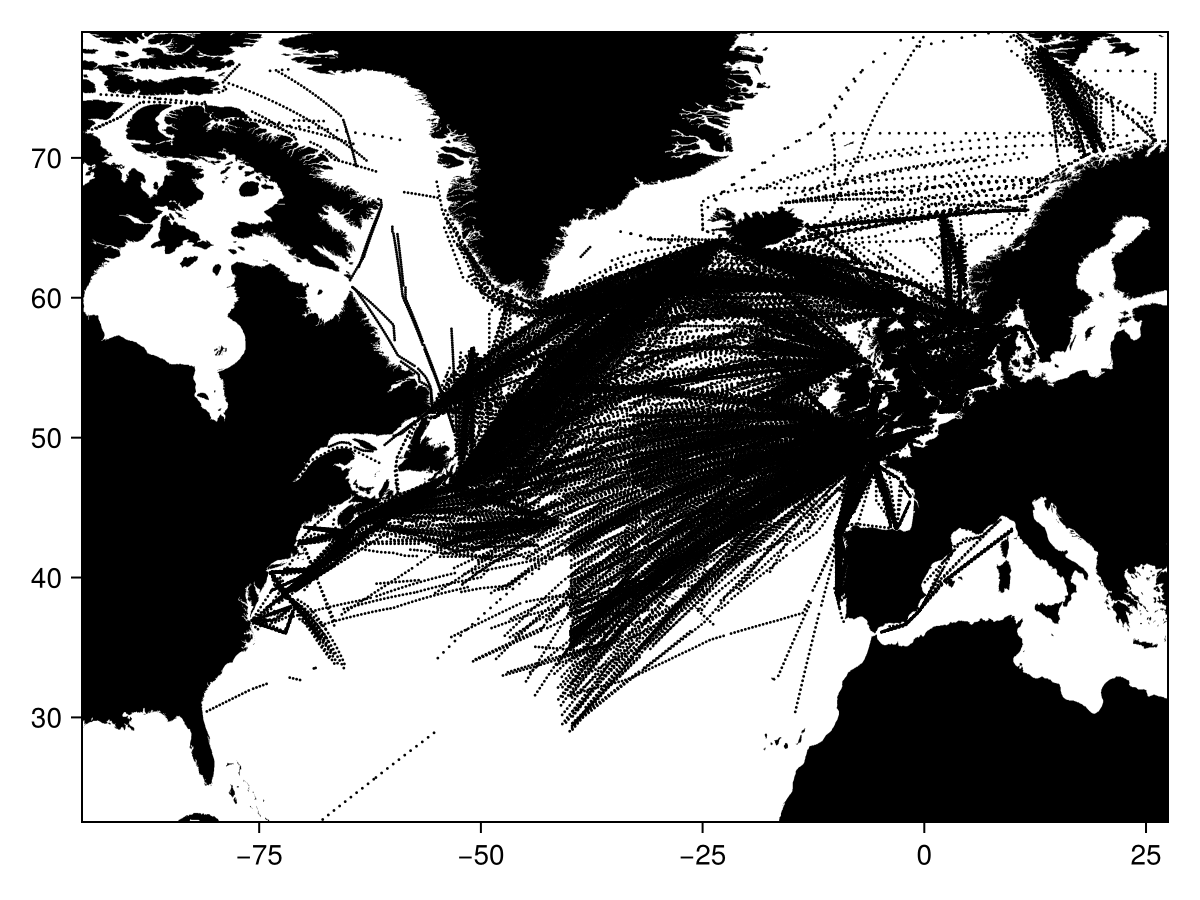

CairoMakie.Screen{IMAGE}


In [12]:
fig = Figure()
ax = Axis(fig[1, 1])
contourf!(ax, lon_landsea, lat_landsea, landsea, colormap = Reverse(:greys), levels = 3)
scatter!(ax, lon, lat, color = :black, markersize = 2)
display(fig)

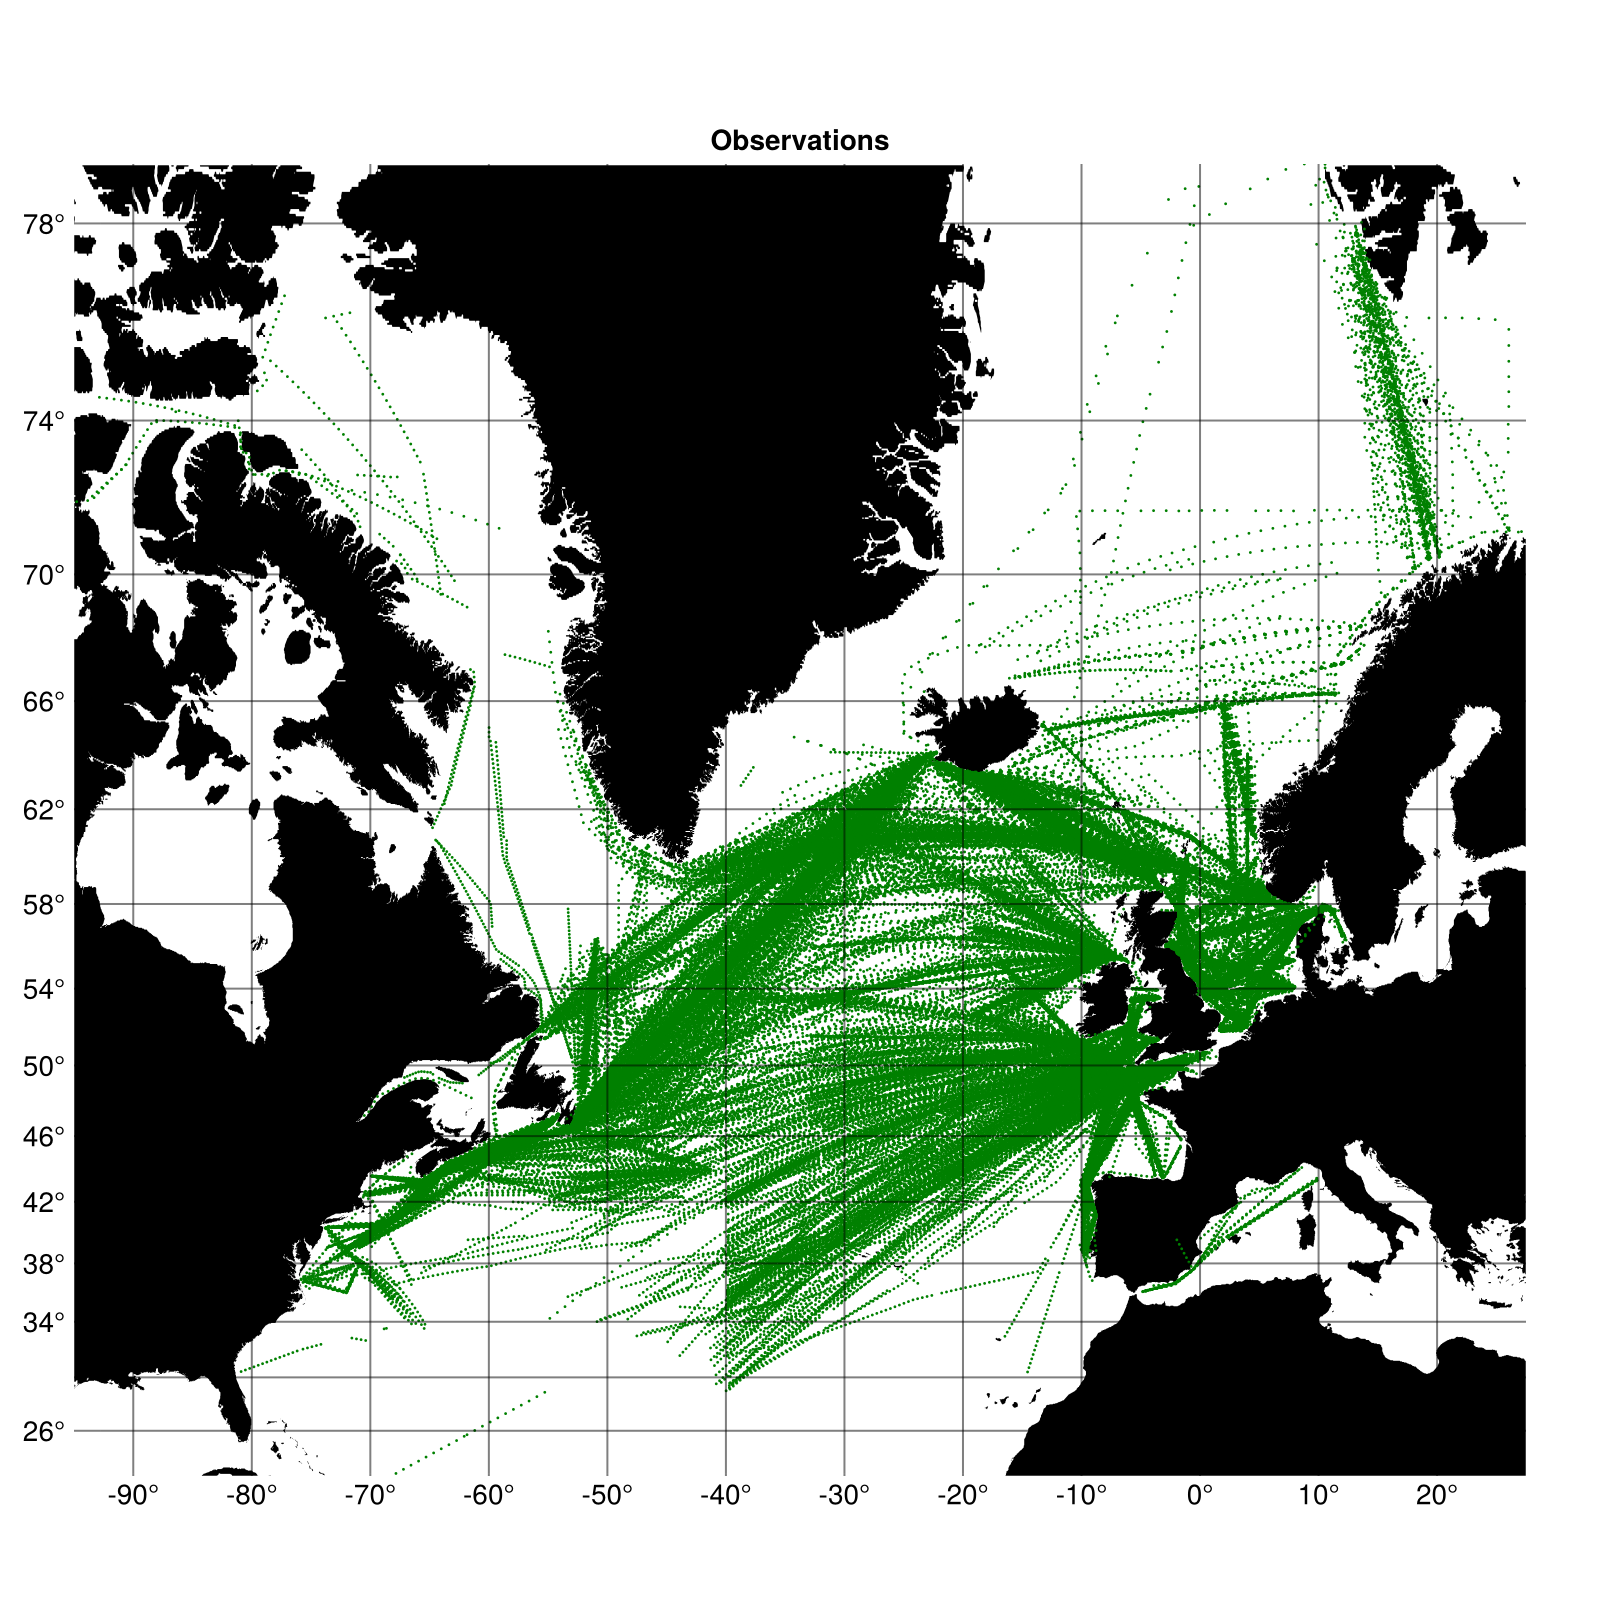

CairoMakie.Screen{IMAGE}


In [18]:
fig = Figure(size = (800, 800))
ax = GeoAxis(fig[1, 1], dest = "proj=merc", title = "Observations")
xlims!(domain[1], domain[2])
ylims!(domain[3], domain[4])
contourf!(ax, lon_landsea, lat_landsea, landsea, colormap = :binary, levels = 2)
scatter!(ax, lon, lat, color = :green, markersize = 2)
save(joinpath(figdir, "data_location.png"), fig)
display(fig)

### Value histograms

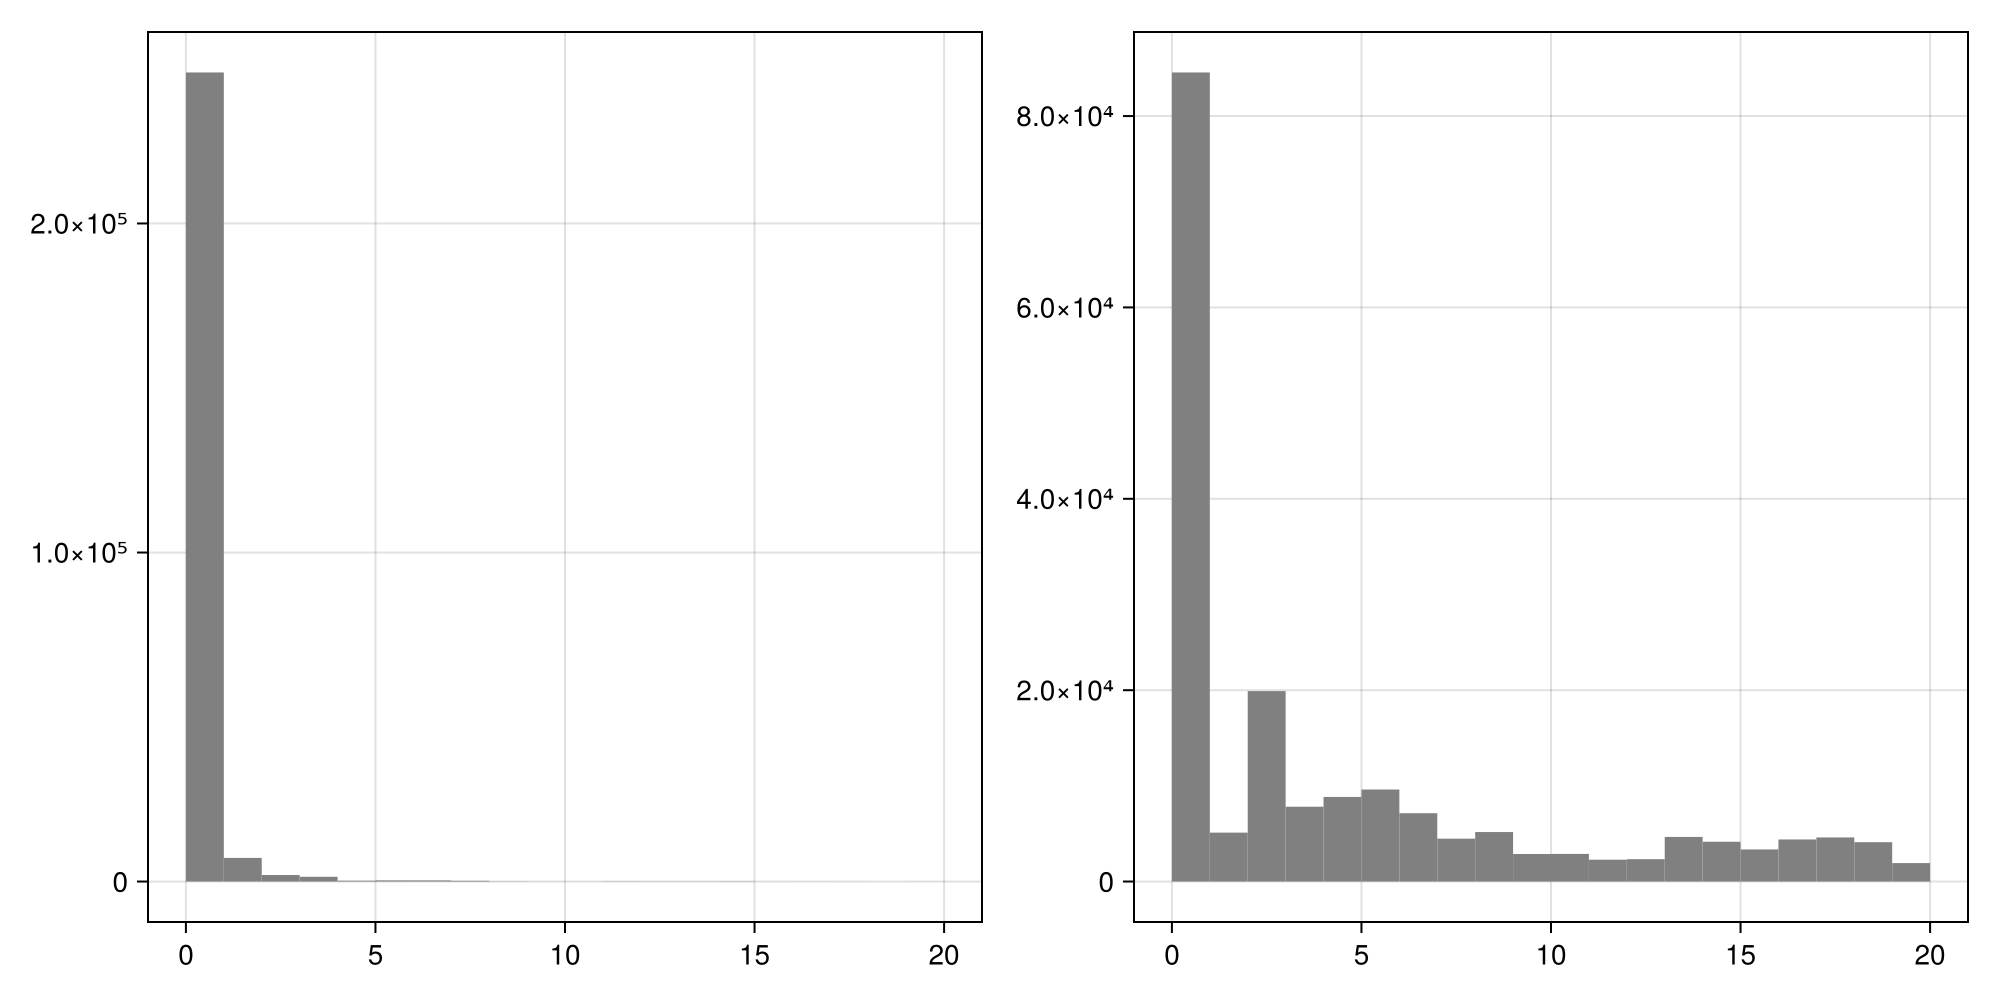

CairoMakie.Screen{IMAGE}


In [13]:
fig = Figure(size = (1000, 500))
ax1 = Axis(fig[1, 1])
hist!(ax1, copepods_small, bins = collect(0:1:20.0), color = :grey)
ax2 = Axis(fig[1, 2])
hist!(ax2, copepods_large, bins = collect(0:1:20.0), color = :grey)
display(fig)

## Write the data in netCDF
### Small copepods

In [21]:
@time obsid, tracknum = CopepodsNN.get_obsid(sampleID);
CopepodsNN.write_netcdf_CPR(
    joinpath(dataprocdir, "Small_copepods_DINCAE.nc"),
    lon,
    lat,
    dates,
    copepods_small,
    "Small_copepods",
    obsid,
    fielddates_monthly,
);

 13.871349 seconds (921.89 k allocations: 522.181 MiB, 0.53% gc time, 0.91% compilation time)


### Large copepods

In [24]:
@time obsid, tracknum = CopepodsNN.get_obsid(sampleID);
CopepodsNN.write_netcdf_CPR(
    joinpath(dataprocdir, "Large_copepods_DINCAE.nc"),
    lon,
    lat,
    dates,
    copepods_large,
    "Large_copepods",
    obsid,
    fielddates_monthly,
);

 13.550429 seconds (679.61 k allocations: 510.570 MiB, 0.51% gc time)
